# Aircraft Engine RUL Prediction

In [51]:
import pandas as pd
import numpy as np
import psycopg2

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler #to normalize data

import os
os.chdir("D:/RulNasa/")

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout
from keras.optimizers import RMSprop,adam
from keras.callbacks import History
from keras import callbacks

In [ ]:
def get_data_from_db(query):
    
    


#establishing the connection
conn = psycopg2.connect(
   database="dataset", user='postgres', password='0125527', host='127.0.0.1', port= '5432'
)
#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Executing an MYSQL function using the execute() method
cursor.execute(query)

# Fetch a single row using fetchone() method.
data = cursor.fetchall()


#Closing the connection
conn.close()

#scores = model.evaluate(x_train, y_train, verbose=1, batch_size=200)
#print('MSE: {}'.format(scores[1]))
return data;

In [52]:
# based on data wrangling python notebook
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + sensor_measure_columns_names

   
    df_train =get_data_from_db()
  
    
    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('train_FD004_2.txt', delim_whitespace=True, names=input_file_column_names)
    

    y_true = pd.read_csv('RUL_FD004.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    
    return df_train, df_test, y_true

## Model

### Data Preprocessing

To make sure that variance of features remain in the same range, it is important to scale the features. If a feature's variance is order of magnitude more than the variance of other features, that particular feature might dominate other features in the dataset, which is not desirable.

In [53]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

feats = [column for column in df_train.columns if column !="RUL"]

min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.fit_transform(df_test[feats])

print(df_test.shape)
print(df_train.shape)

(11249, 17)
(50000, 18)



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [54]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    
    print(num_elements)
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [55]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [56]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
  #  df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
   # df_mask[:] = mask_value
    
   # id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = 0
    #num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [57]:
sequence_length = 50
mask_value = 0


Let's prepare data using above functions.

In [58]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

321
299
307
274
193
331
221
230
334
354
301
272
256
253
224
184
151
343
210
245
227
211
280
186
150
297
163
202
247
297
263
219
201
276
221
143
388
177
202
206
279
280
223
203
177
321
375
322
446
172
285
357
304
197
344
347
193
281
177
218
244
297
170
184
351
175
167
163
226
185
312
308
181
244
230
152
148
250
218
305
187
197
184
159
277
232
259
388
168
212
354
191
196
249
239
270
262
245
167
261
260
194
224
203
170
266
183
304
325
186
297
340
184
161
131
344
342
543
187
177
194
174
226
170
239
302
235
248
190
166
370
254
489
247
149
205
225
178
251
298
199
209
184
297
228
303
234
193
261
149
351
262
168
203
295
139
298
399
288
187
303
313
285
380
255
269
263
196
227
161
399
273
457
370
156
180
242
170
435
344
134
205
190
379
259
163
273
254
239
381
297
190
197
145
159
174
170
164
176
225
378
241
84
(40053, 50, 17)


In [59]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(40053,)

In [60]:
#generate test
x_test=np.concatenate(list(list(gen_train(df_test[df_test['UnitNumber']==unit], sequence_length, feats)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

240
211
242
263
379
290
161
167
146
229
197
128
361
244
200
236
190
202
274
202
247
268
418
194
287
279
280
250
194
273
289
207
199
225
212
187
365
149
332
222
327
267
205
161
211
184
255
(8946, 50, 17)


In [67]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape
x_test.shape

(8946, 50, 17)

### LSTM Model

In [62]:
nb_features = x_train.shape[2]
nb_out = 1

In [63]:
nb_features

17

In [64]:
history = History()

model = Sequential()
model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))
model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           47200     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 127,701
Trainable params: 127,701
Non-trai

In [65]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
          callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100
1127/1127 [==============================] - 44s 35ms/step - loss: 9872.4072 - mse: 9872.4072 - val_loss: 5881.9009 - val_mse: 5881.9009
Epoch 2/100
1127/1127 [==============================] - 39s 34ms/step - loss: 4573.6274 - mse: 4573.6274 - val_loss: 6769.8662 - val_mse: 6769.8662
Epoch 3/100
1127/1127 [==============================] - 39s 34ms/step - loss: 2951.9712 - mse: 2951.9712 - val_loss: 3801.2346 - val_mse: 3801.2346
Epoch 4/100
1127/1127 [==============================] - 39s 35ms/step - loss: 2544.0476 - mse: 2544.0476 - val_loss: 4912.8574 - val_mse: 4912.8574
Epoch 5/100
1127/1127 [==============================] - 39s 35ms/step - loss: 2266.3052 - mse: 2266.3052 - val_loss: 5808.2861 - val_mse: 5808.2861
Epoch 6/100
1127/1127 [==============================] - 40s 36ms/step - loss: 1860.8979 - mse: 1860.8979 - val_loss: 16076.2959 - val_mse: 16076.2959
Epoch 7/100
1127/1127 [==============================] - 39s 35ms/step - loss: 1437.8735 - mse: 1437.873

Let's plot the loss

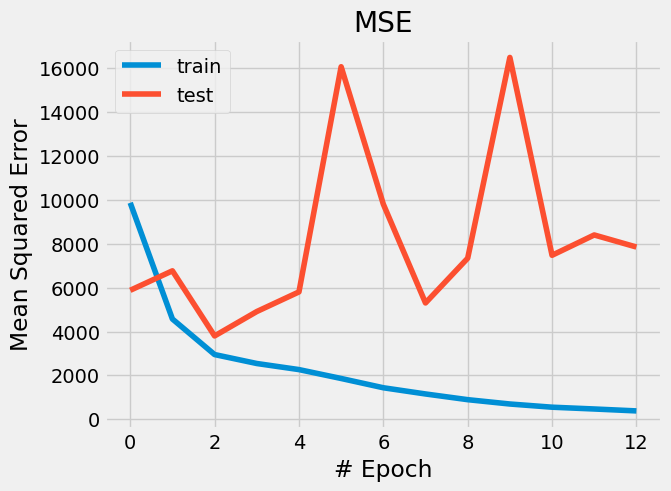

In [68]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Results on Train Set

Connection established to:  ('PostgreSQL 15.2, compiled by Visual C++ build 1914, 64-bit',)


### Results on Test Set

In [70]:
scores_test = model.evaluate(x_test, y_test, verbose=2)
print('MSE: {}'.format(scores_test[1]))

ValueError: Data cardinality is ambiguous:
  x sizes: 8946
  y sizes: 248
Make sure all arrays contain the same number of samples.

In [ ]:
y_pred_test = model.predict(x_test, verbose=0)

plt.figure(figsize=(30,20))
plt.plot(y_pred_test, color='orange', label='Prediction')
plt.plot(y_test, color='green', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()